In [9]:
import numpy as np
import pandas as pd
from Levenshtein import distance
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

## Data Processing

In [138]:
# --- get list of file names --- #
directory = "data/IGHV1_58_repertoires"
directory_contents = os.listdir(directory)

# filtering function
def filter_condition(string):
    return "clone-pass.tsv" in string

file_names = [file for file in directory_contents if filter_condition(file)]

# print(file_names)


In [148]:
# --- parameters --- #
target_junction_length = 54 # 3 * number of amino acids

# ----- read in and process data into master pd dataframe ----- #
full_data = pd.DataFrame()

for file in file_names:
    file_data = pd.read_csv(directory + '/' + file, sep = '\t')

    # print(file_data.keys()) # prints columns
    # - select columns
    file_data = file_data[["sequence_id", "sample_id", "subject_id", "clone_id", "v_call", "j_call", "junction_aa", "junction_length", "locus"]]


    # # --- filter data --- #
    # file_data = file_data.loc[(file_data["junction_length"] == target_junction_length) & 
    #                           (file_data["locus"] == "IGH")
    #                           ]
    # # - filter v_call, j_call? ^

    # # - remove duplicates - !! doesn't remove duplicates across diff samples but same individual
    # file_data = file_data.drop_duplicates(["junction_aa"]) # can count duplicates instead if we want expression level


    # --- concatenate to full data DF
    full_data = pd.concat([full_data, file_data])

# print(full_data.shape) # (32248, 8)
    

In [149]:


# ----- filter data ----- #
# - filter junction length; locus (keep heavy chains only)
filtered_data = full_data.loc[(full_data["junction_length"] == target_junction_length) & 
                              (full_data["locus"] == "IGH")
                              ]

# - filter v_call/j_call (TO IMPLEMENT IF NEEDED)
# string separation

# - remove duplicates
filtered_data = filtered_data.drop_duplicates(["subject_id",  "junction_aa"])

# print(filtered_data.shape) # (1790, 8)

# - select certain list of subjects, etc.
# filter_list = []

# reset index to 0, 1, ...
filtered_data = filtered_data.reset_index(drop=True)

filtered_data.head()

,sequence_id,sample_id,subject_id,clone_id,v_call,j_call,junction_aa,junction_length,locus
0,5f48586f869e21b4c2be5c84,S22-rep3,S22,14068,IGHV1-58*02,"IGHJ4*01,IGHJ4*02",CTTEVKWELGKAPYFDYW,54,IGH
1,5f48586f869e21b4c2be5c85,S22-rep3,S22,14069,IGHV1-58*02,IGHJ4*02,CARDLLGSEDTAMVRDHW,54,IGH
2,5f48586f869e21b4c2be5c86,S22-rep3,S22,14070,IGHV1-58*02,IGHJ4*02,CAAADYGDSRGKSSFDYW,54,IGH
3,5f48586f869e21b4c2be5c8b,S22-rep3,S22,14070,IGHV1-58*02,"IGHJ4*01,IGHJ4*02",CAAADYGDSWGKSSFDYW,54,IGH
4,5f48586f869e21b4c2be5c8a,S22-rep3,S22,14071,IGHV1-58*02,IGHJ4*02,CARDAPGLEIWFGELNYW,54,IGH


In [150]:
# --- data parameters (for graphing) --- #
n = filtered_data.shape[0]
subjects_list = filtered_data["subject_id"].unique() # set
n_subjects = len(subjects_list) # 68


## Compute distance + adjacency matrix

In [151]:
# use full_data to access data (index = node label)
# --- create distance matrix --- #
# normalized hamming distance
def hamming_distance_norm_str(str1, str2):
    assert len(str1) == len(str2)
    return sum(c1 != c2 for c1, c2 in zip(str1, str2)) / len(str1)

junction_aa_data = pd.DataFrame(filtered_data["junction_aa"])

# compute distances
pairwise_distances = pdist(junction_aa_data, lambda x,y: hamming_distance_norm_str(x[0], y[0])) # grab str1 from [str1]
distance_matrix = squareform(pairwise_distances)
# print(distance_matrix.shape) # (1790, 1790)
# print(type(distance_matrix)) # numpy ndarray

In [152]:
# --- create adjacency matrix --- #
# threshold adjacency matrix - can loop instead
threshold = 3.0/18.0

boolean_matrix = (distance_matrix <= threshold)
adjacency_matrix = boolean_matrix * 1 # boolean to 0/1. 
np.fill_diagonal(adjacency_matrix, 0) # no self-edges
# print(adjacency_matrix)

# average degree of a node
print(np.sum(adjacency_matrix) / (2 * adjacency_matrix.shape[0]))

1.6726256983240224


## Graph creation and analysis

In [153]:
# --- create graph from adjacency matrix --- #
G = nx.from_numpy_array(adjacency_matrix)

# len(G.nodes) # 1790
# len(G.edges) # 2994

# --- add in attribute data --- #
# for loop
for i in range(n):
    # add in attributes of individual, sequence
    G.nodes[i]["subject_id"] = filtered_data.iloc[i]["subject_id"]
    G.nodes[i]["junction_aa"] = filtered_data.iloc[i]["junction_aa"]

# G.nodes.data()

In [154]:
# --- plot basic graph --- #
# nx.draw(G) # just nodes in a circle; can't really see edges
# nx.draw_networkx(G, node_size=20, width=2, with_labels=False)

# --- color points by attribute? either from graph data or external node metadata --- #
# seaborn color palette; dictionary mapping
# subjects_list

rgb_values = sns.color_palette(n_colors = n_subjects)

color_map = dict(zip(subjects_list, rgb_values)) # !! contains repeats if too many unique subjects

filtered_data["color"] = filtered_data["subject_id"].map(color_map)

colors_palette = filtered_data["color"]

# print(full_data["color"])
# print(color_map) 

# --- plot graph with customization --- #
# nx.draw_networkx(G, node_size=10, width=5, with_labels=False, node_color = colors_palette) # takes a long time

# --- check out other graph python libraries suggested in CPSC 483 notes somewhere --- #

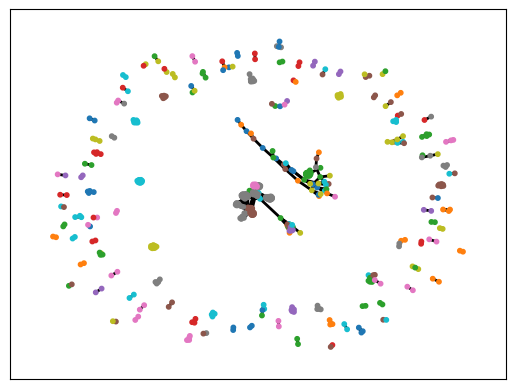

In [155]:
# ----- remove isolated nodes ----- #
isolated_nodes = list(nx.isolates(G)) # len = 1228
nonisolated_nodes = [i for i in G.nodes if not nx.is_isolate(G, i)] # len = 562

# - version 1: change graph G itself - easy implementation, bad practically
# G.remove_nodes_from(isolated_nodes) # bad since it mutates graph G; try storing in new graph

# - version 2: subgraph - easy implementation, read only(?)
# G_connected_components = G.subgraph(nonisolated_nodes) # subgraph view (ie. view-only!)

# - version 3: deepcopy of the graph - memory constraints?
# G_connected_components = copy.deepcopy(G) # check python package

# - version 3': shallow copy - node labels are not 0, 1, ...
# https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.copy.html
# independent shallow copy: attributes that are containers are shared between old and new graph
# new attributes are only in the new graph I think
G_connected_components = G.copy()
G_connected_components.remove_nodes_from(isolated_nodes) # 562 

# - version 4: filter the DF; change the adjacency matrix accodingly; recreate graph
connected_data = filtered_data.drop(isolated_nodes, axis=0) 
# print(connected_data.shape) # 562, 9

# --- parameters --- #
n_connected = connected_data.shape[0]
connected_subjects_list = connected_data["subject_id"].unique() # set
n_connected_subjects = len(connected_subjects_list) # 53

# --- redo color palette in case number of subjects changed --- #
# seaborn color palette; dictionary mapping

rgb_values = sns.color_palette(n_colors = n_connected_subjects)
color_map = dict(zip(connected_subjects_list, rgb_values)) # !! contains repeats if too many unique subjects
connected_data["color"] = connected_data["subject_id"].map(color_map)
colors_palette2 = connected_data["color"]

# --- plot --- #
nx.draw_networkx(G_connected_components, node_size=10, width=2, with_labels=False, node_color = colors_palette2)


In [ ]:
# ----- generalized subgraph procedure ----- #
def remove_node_condition(graph, i):
    return nx.is_isolate(graph, i)

def keep_node_condition(graph, i):
    return not nx.is_isolate(graph, i)

# pass in graph, corresponding data, remove or keep condition (functions)
# returns new graph and dataframe (with colors per subject)
def create_subgraph(graph, dataframe, remove_condition = None, keep_condition = None):
    return

In [58]:
# --- identify sequences satisfying condition --- #
target_num_neighbor_types = 6 # number of unique neighbor subject_id's required
list_of_intersections = [] 

for node, neighbors in G.adj.items():
    neighbor_set = set()
    # n_indiv = 2 # defined previously in parameter section

    # loop - can compute statistics for nodes and add them as attributes
    for neighbor, edge_attribute in neighbors.items():
        # print(neighbor) # index (ie. 1, 2, etc.)
        neighbor_set.add(G.nodes[neighbor]["subject_id"])

    # condition for adding to set we want
    if len(neighbor_set) >= target_num_neighbor_types: 
        list_of_intersections.append(G.nodes[node]["junction_aa"])

print(list_of_intersections)

['CAAVYCSSTSCFDAFDIW', 'CAAPNCSSTSCYSAFDIW', 'CAAPYCSSTSCSDAFDIW', 'CASPYCSSTSCSDAFDIW', 'CAADSSGYYYYYYGMDVW', 'CAAPYCSSTSCSDAFDIW', 'CAAPYCSSTSCDDAFDIW', 'CAAVYCSSTSCSDAFDIW', 'CAAPYCSGGSCHDAFDIW', 'CAAPYCSSTSCYDAFDIW', 'CAAPYCSSTSCHDAFDIW', 'CAAPHCSTTSCYDAFDIW', 'CAAPYCSSTSCHDAFDIW', 'CAAPYCSSTSCYDAFDIW', 'CAAVTCSSTSCYDAFDIW', 'CASPDCSSTSCYDAFDIW']


In [159]:
# --- connected components analysis --- #
for c in nx.connected_components(G_connected_components): 
    # - print all >= number
    # if len(c) >= 2:
        # print(c)

    # - print all with >= 2 subjects
    c_subject_list = connected_data.loc[list(c)]["subject_id"].unique() # loc goes by row index/column names
    # c_subject_list = filtered_data.iloc[list(c)]["subject_id"].unique() # iloc goes by integer location
    if len(c_subject_list) >= 2:
        print(c)

print(G_connected_components.nodes[1536]["junction_aa"])



{1536, 1537, 6, 1414, 270, 1038, 271, 1688, 1437, 543, 428, 1330, 1715, 1716, 1717, 445, 708, 581, 709, 711, 712, 1735, 842, 843, 844, 710, 1497, 1498, 1251, 998, 999, 1135, 243, 1396, 1397, 761}
{31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 300}
{1410, 1160, 655, 88, 1470}
{114, 867}
{1025, 1538, 1539, 1039, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1094, 1095, 1096, 610, 611, 612, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 1748, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 765, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 12

In [136]:
# --- centrality testing --- #
# print(nx.degree_centrality(G_connected_components))
# print(nx.eigenvector_centrality(G_connected_components)) # failed to converge